In [1]:
# commonly used libraries
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la

# PIL: for image data extraction and image enhancement
from PIL import Image

# CV2: only for demostration purpose, not included in implementation
import cv2


In [2]:
def readImgAndTime(name, imgFormat, convertToCV2) :
    """Reads the set of 3 images in dir images by the name

    Args:
    name (str): the name of the set of images
    imgFormat (str): the format of the set of images
    convertToCV2 (bool): whether convert the returning image to cv2 format

    Returns:
    images: an array of images
    times: an array of exposure times
    """
    name_under = "images/" + name + "-2EV" + imgFormat
    name_normal = "images/" + name + "+0EV" + imgFormat
    name_over = "images/" + name + "+2EV" + imgFormat
    
    im_under = Image.open(name_under)
    im_normal = Image.open(name_normal)
    im_over = Image.open(name_over)
    
    images = [im_under, im_normal, im_over]
    times = []
    for img in images:
        exifdata = img._getexif()
        
        data = exifdata[33434]
        
        # get the exposure time

        if isinstance(data, bytes):
            data = data.decode()
        times += [data]

    
    if convertToCV2 :
        # convert to cv2 format
        im_under = cv2.imread(name_under)
        im_normal = cv2.imread(name_normal)
        im_over = cv2.imread(name_over)
        images = np.array([im_under, im_normal, im_over])
    times = np.array(times, dtype=np.float32)
                
    return images, times

def showImages(images, times):
    fig = plt.figure(figsize = (30, 10))
    plt.subplot(131)
    plt.title("Under Exposed Image - exposure time: " + "1/"+str(round(1/times[0])))
    plt.imshow(images[0])
    plt.subplot(132)
    plt.title("Camera Auto Exposed Image - exposure time: " + "1/"+str(round(1/times[1],0)))
    plt.imshow(images[1])
    plt.subplot(133)
    plt.title("Over Exposed Image - exposure time: " + "1/"+str(round(1/times[2],0)))
    plt.imshow(images[2])
    plt.show()
    
def showCVImages(CVimages, times):
    cv2.imwrite('images/tmp0.jpeg', CVimages[0])
    cv2.imwrite('images/tmp1.jpeg', CVimages[1])
    cv2.imwrite('images/tmp2.jpeg', CVimages[2])
    
    im0 = Image.open('images/tmp0.jpeg')
    im1 = Image.open('images/tmp1.jpeg')
    im2 = Image.open('images/tmp2.jpeg')
    PILimages = [im0, im1, im2]
    
    showImages(PILimages, times)
    
def showCVImage(CVimage):
    cv2.imwrite('images/tmp0.jpeg', CVimage)

    im0 = Image.open('images/tmp0.jpeg')
    
    plt.imshow(im0)
    plt.show()

#### Step 1: Read the images using the above helpers

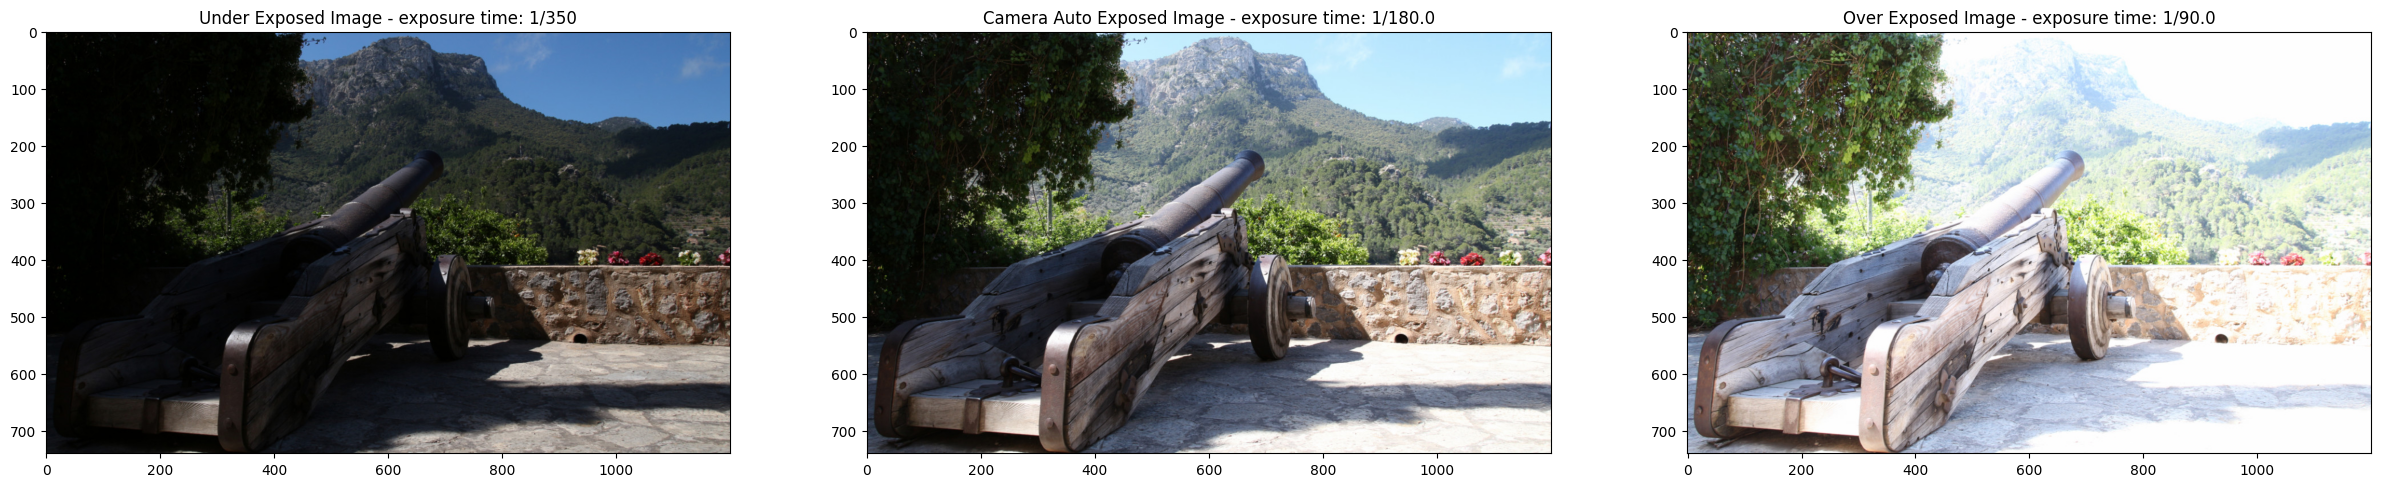

In [3]:
# read the images and times in the PIL format
images, times = readImgAndTime("cannon", ".jpeg", False)
showImages(images, times)

#### Step 2: Film Response Recovery
1. Setting up params for gsolve
2. Finding g and ln E

(3, 900)
(2957, 1156)
(2957, 1)


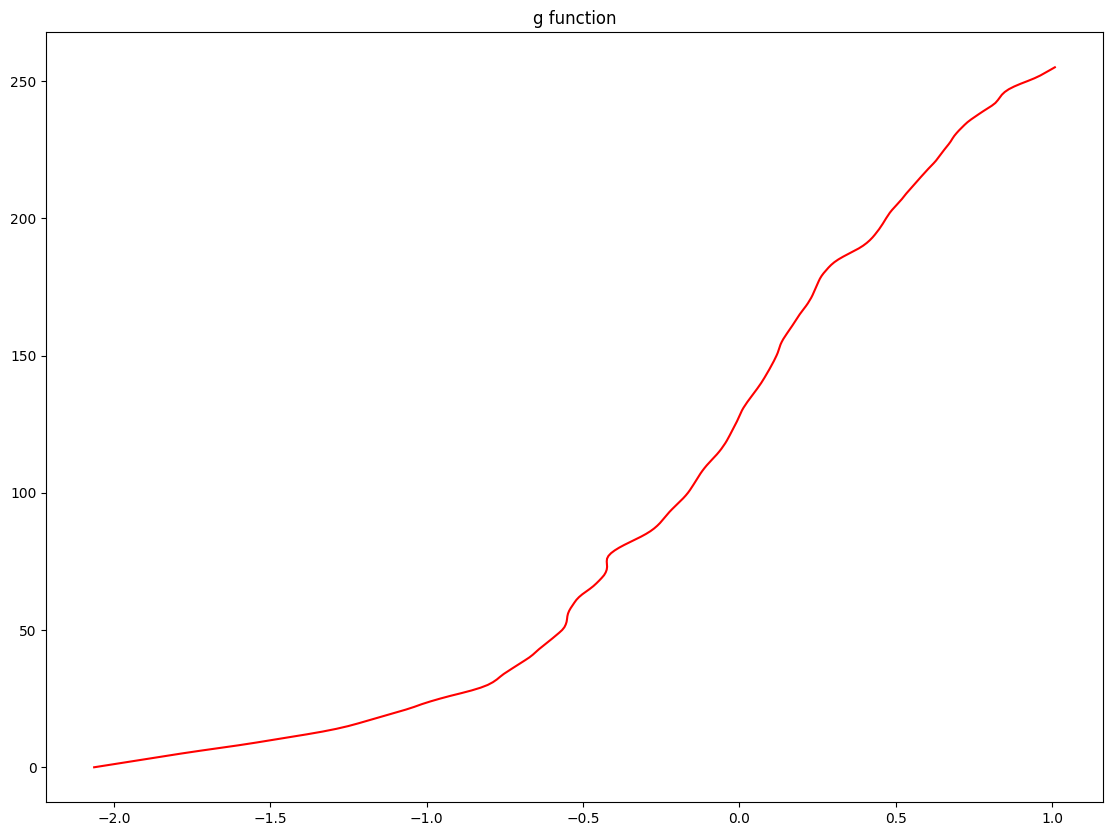

In [4]:
# setting up data for gsolve
# create Z such that its shape is (numPixels, numImages)
# where numPixels = width * height
# and numImages = 3
# cast all images to np arrays with same shape
images_np = []
for image in images:
    image = np.array(image)
    images_np += [image]
images = np.array(images_np)

def setup_data_for_gsolve(single_channeled_images, times):
    """
    Setting up data for gsolve
    create Z such that its shape is (numPixels, numImages)
    where numPixels = width * height
    and numImages = 3
    
    Args:
    images (list): a list of PIL images
    times (list): a list of exposure times
    
    Returns:
    Z (numpy.ndarray): an array of shape (numPixels, numImages)
    """

    num_images = single_channeled_images.shape[0]

    z_min = 0
    z_max = 255
    z_mid = (z_min + z_max) / 2 # 128

    # setup Z
    # width, height = single_channeled_images[0].shape
    # Z = np.zeros((num_images, width*height))
    # for j in range(num_images):
    #     Z[j] = single_channeled_images[j].flatten()

    # the above approach is memory intensive. I just need the middle 30 pixels in each 2D image
    Z = np.zeros((num_images, 30*30))
    for j in range(num_images):
        x_middle = single_channeled_images[j].shape[0] // 2
        y_middle = single_channeled_images[j].shape[1] // 2
        #need 100 pixels across the middle
        Z[j] = single_channeled_images[j][x_middle-15:x_middle+15, y_middle-15:y_middle+15].flatten()

    # setup w
    w = np.zeros(256)
    for i in range(256):
        if i <= z_mid:
            w[i] = i - z_min
        else:
            w[i] = z_max - i

    B = np.log(times)


    return Z, B, w


def gsolve(Z, B, coeff_smooth, w):
    #generate docstring
    """Computes the camera response function for each color channel"""

    n = len(w)
    #print nrows and ncolumns of Z
    n_images, n_pixels = Z.shape
    print(Z.shape)


    A = np.zeros((n_images * n_pixels + n + 1, n + n_pixels))
    b = np.zeros((A.shape[0], 1))
    print(A.shape)
    print(b.shape)
    # return

    #include the data-fitting equations
    k = 0
    for j in range(n_images):
        for i in range(n_pixels):
            z = int(Z[j, i])
            w_ij = w[z]
            A[k, z] = w_ij
            A[k, n + i] = -w_ij
            b[k] = w_ij * B[j]
            k += 1

    # fix the curve by setting mid value to 1
    A[k, 128] = 1
    k += 1

    # include the smoothness equations
    for i in range(1, n-1): # skip Z_min (0) and Z_max (256)
        A[k][i] = -2  * coeff_smooth * w[i] # current pixel term is weighted higher
        A[k][i + 1] = coeff_smooth * w[i] # right pixel term
        A[k][i - 1] = coeff_smooth * w[i] # left pixel term
        k += 1 # move to the next row

    # solve the system of equations
    pseudo_inverse = la.pinv(A)
    x = np.dot(pseudo_inverse, b)

    g = x[:n]
    logE = x[n:]

    return g, logE

Z_red, B_red, w = setup_data_for_gsolve(images[:, :, :, 0], times)
g, logE = gsolve(Z_red, B_red, 10, w)
# plot function g and logE against 256
fig = plt.figure(figsize = (30, 10))
# plot multiple lines on the same figure

plt.subplot(121)
plt.title("g function")
plt.plot(g, range(256), 'r', label = "red response curve")

#### Step 3: Constructing the HDR Radiance Map